# 挖掘幸福感

tianchi: https://tianchi.aliyun.com/competition/entrance/231702/introduction

## Utils, Data

In [211]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [212]:
# 先读取abbr精简版查看情况
# train_abbr = pd.read_csv('./data/happiness_train_abbr.csv', encoding='ISO-8859-1')
# test_abbr = pd.read_csv('./data/happiness_test_abbr.csv', encoding='ISO-8859-1')
train_complete = pd.read_csv('./data/happiness_train_complete.csv', encoding='ISO-8859-1')
test_complete = pd.read_csv('./data/happiness_test_complete.csv', encoding='ISO-8859-1')

# train_abbr.shape, test_abbr.shape
print(f'training set shape: {train_complete.shape}, testing set shape: {test_complete.shape}')

training set shape: (8000, 140), testing set shape: (2968, 139)


In [213]:
# pd.set_option('display.max_rows', None)
# print(train_abbr.isna().sum())
# print(test_abbr.isna().sum())
# print(train_abbr.info())

# print(train_complete.isnull().sum())
# print(test_complete.isnull().sum())
print(train_complete.info())
print(train_complete['happiness'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 140 entries, id to public_service_9
dtypes: float64(25), int64(111), object(4)
memory usage: 8.5+ MB
None
 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64


## Preprocess

In [214]:
# 筛选出非数值的列
obj_ = train_complete.dtypes[train_complete.dtypes == 'object'].index
# 筛选缺失值比例大于0.5的列
lotnan = train_complete.isna().sum()[train_complete.isna().sum() > 4000].index
print(obj_)
print(lotnan)

Index(['survey_time', 'edu_other', 'property_other', 'invest_other'], dtype='object')
Index(['edu_other', 'join_party', 'property_other', 'work_status', 'work_yr',
       'work_type', 'work_manage', 'invest_other', 's_work_status',
       's_work_type'],
      dtype='object')


In [215]:
# 删除目标列为 -8 的样本
# train_abbr.drop(train_abbr[train_abbr['happiness'] < 0].index, inplace=True)
train_complete.drop(train_complete[train_complete['happiness'] < 0].index, inplace=True)
# 删除缺失值比列大于0.5的列
train_complete.drop(lotnan, axis=1, inplace=True)
test_complete.drop(lotnan, axis=1, inplace=True)

print(f'training set shape: {train_complete.shape}, testing set shape: {test_complete.shape}')

training set shape: (7988, 130), testing set shape: (2968, 129)


In [216]:
labels = train_complete['happiness'].values
# 由于分类值从1开始，默认为0
labels = labels - 1
train_complete.drop(['happiness'], axis=1, inplace=True)

# train_abbr.drop(['happiness'], axis=1, inplace=True)
# data_abbr = pd.concat([train_abbr, test_abbr])

# 去掉id列以及非数值的列
# data_abbr.drop(['id', 'survey_time'], axis=1, inplace=True)
data_complete = pd.concat([train_complete, test_complete])
data_complete.drop(['id', 'survey_time'], axis=1, inplace=True)

print(f'all features shape: {data_complete.shape}')
data_complete.head(10)

all features shape: (10956, 127)


,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,12,32,59,1,1959,1,1,1,11,...,4,50,60.0,50,50,30.0,30,50,50,50
1,2,18,52,85,1,1992,1,1,1,12,...,3,90,70.0,70,80,85.0,70,90,60,60
2,2,29,83,126,2,1967,1,0,3,4,...,4,90,80.0,75,79,80.0,90,90,90,75
3,2,10,28,51,2,1943,1,1,1,3,...,3,100,90.0,70,80,80.0,90,90,80,80
4,1,7,18,36,2,1994,1,1,1,12,...,2,50,50.0,50,50,50.0,50,50,50,50
5,2,18,52,86,1,1946,1,1,1,2,...,4,90,90.0,90,90,90.0,90,80,90,90
6,1,10,27,49,1,1963,1,1,1,4,...,4,80,80.0,50,70,60.0,50,60,80,80
7,1,11,31,54,1,1959,1,0,8,4,...,4,70,70.0,70,70,70.0,70,80,70,70
8,2,28,81,122,1,1952,1,1,1,3,...,5,82,70.0,60,82,84.0,85,86,87,85
9,2,24,70,110,1,1985,1,1,1,3,...,5,60,60.0,60,60,60.0,60,60,60,60


In [217]:
# 将输入做归一化处理

# data_abbr.apply(normalization)
# data_abbr = data_abbr.fillna(0)
data_complete = data_complete.apply(lambda x: (x - x.mean()) / x.std())
data_complete = data_complete.fillna(data_complete.interpolate())

print(f'all features shape: {data_complete.shape}')
data_complete.head(10)

all features shape: (10956, 127)


,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,...,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,-0.834371,-0.358792,-0.393049,-0.305307,-1.066412,-0.331253,-0.245739,0.213122,-0.303309,1.941083,...,0.242768,-0.991900,-0.402804,-0.522537,-0.745598,-1.427122,-1.729789,-0.698088,-0.666802,-0.781165
1,1.198399,0.314389,0.342948,0.366949,-1.066412,1.621207,-0.245739,0.213122,-0.303309,2.257220,...,-0.634753,0.904059,0.084756,0.286187,0.615138,0.937591,0.129840,1.035168,-0.244905,-0.332353
2,1.198399,1.548553,1.483745,1.427046,0.937638,0.142071,-0.245739,-0.737211,1.110456,-0.271873,...,0.242768,0.904059,0.572315,0.488368,0.569781,0.722617,1.059654,1.035168,1.020786,0.340865
3,1.198399,-0.583186,-0.540249,-0.512155,0.937638,-1.277901,-0.245739,0.213122,-0.303309,-0.588009,...,-0.634753,1.378048,1.059875,0.286187,0.615138,0.722617,1.059654,1.035168,0.598889,0.565271
4,-0.834371,-0.919776,-0.908248,-0.899995,0.937638,1.739538,-0.245739,0.213122,-0.303309,2.257220,...,-1.512274,-0.991900,-0.890364,-0.522537,-0.745598,-0.567226,-0.799975,-0.698088,-0.666802,-0.781165
5,1.198399,0.314389,0.342948,0.392805,-1.066412,-1.100404,-0.245739,0.213122,-0.303309,-0.904146,...,0.242768,0.904059,1.059875,1.094911,1.068717,1.152565,1.059654,0.601854,1.020786,1.014084
6,-0.834371,-0.583186,-0.577049,-0.563867,-1.066412,-0.094591,-0.245739,0.213122,-0.303309,-0.271873,...,0.242768,0.430069,0.572315,-0.522537,0.161560,-0.137278,-0.799975,-0.264774,0.598889,0.565271
7,-0.834371,-0.470989,-0.429849,-0.434587,-1.066412,-0.331253,-0.245739,-0.737211,4.644869,-0.271873,...,0.242768,-0.043921,0.084756,0.286187,0.161560,0.292670,0.129840,0.601854,0.176992,0.116459
8,1.198399,1.436357,1.410145,1.323622,-1.066412,-0.745411,-0.245739,0.213122,-0.303309,-0.588009,...,1.120289,0.524867,0.084756,-0.118175,0.705854,0.894597,0.827201,0.861842,0.894217,0.789678
9,1.198399,0.987569,1.005346,1.013350,-1.066412,1.207049,-0.245739,0.213122,-0.303309,-0.588009,...,1.120289,-0.517910,-0.402804,-0.118175,-0.292019,-0.137278,-0.335068,-0.264774,-0.244905,-0.332353


## Dataset

In [218]:
class Dataset(Dataset):
    def __init__(self, input, label):
        self.input = input
        self.label = label
        self.len = input.shape[0]

    def __getitem__(self, index):
        if self.label is None:
            return self.input[index]
        return self.input[index], self.label[index]

    def __len__(self):
        return self.len

In [219]:
# trainset_abbr = torch.tensor(data_abbr[:len(train_abbr)].values, dtype=torch.float32)
# testset_abbr = torch.tensor(data_abbr[len(train_abbr):].values, dtype=torch.float32)
trainset_comp = torch.tensor(data_complete[:len(train_complete)].values, dtype=torch.float32)
testset_comp = torch.tensor(data_complete[len(train_complete):].values, dtype=torch.float32)

# trainset_abbr_label = torch.tensor(labels[:len(train_abbr)], dtype=torch.long)
# testset_abbr_label = torch.tensor(labels[len(train_abbr):], dtype=torch.long)
trainset_comp_label = torch.tensor(labels[:len(train_complete)], dtype=torch.long)

# train_x, val_x, train_y, val_y = train_test_split(trainset_abbr, trainset_abbr_label, test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(trainset_comp, trainset_comp_label, test_size=0.2, random_state=42)

train_x.shape, val_x.shape, train_y.shape, val_y.shape

(torch.Size([6390, 127]),
 torch.Size([1598, 127]),
 torch.Size([6390]),
 torch.Size([1598]))

In [220]:
batch_size = 512

train_dataset = Dataset(train_x, train_y)
val_dataset = Dataset(val_x, val_y)
test_dataset = Dataset(testset_comp, None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model

In [221]:
# CrossEntropyLoss函数包括了softmax和计算交叉熵两个过程。
loss = nn.CrossEntropyLoss()
in_ = train_x.shape[1]

DNN = nn.Sequential(
    nn.Linear(in_, 64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 5),
)
LR = LogisticRegression(max_iter=1e5)

DNN, LR

(Sequential(
   (0): Linear(in_features=127, out_features=64, bias=True)
   (1): ReLU()
   (2): Dropout(p=0.5, inplace=False)
   (3): Linear(in_features=64, out_features=5, bias=True)
 ),
 LogisticRegression(max_iter=100000.0))

In [222]:
def train(model, epochs, lr, weight_decay, train_loader, val_loader):
    train_loss, val_loss = [], []
    total_train_acc, total_val_acc = [], []
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        train_ls = 0.0
        val_ls = 0.0
        train_acc = 0.0
        val_acc = 0.0

        model.train()
        for i, (input, label) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = model(input)
            batch_loss = loss(pred, label)
            acc = accuracy_score(label, np.argmax(pred.detach().numpy(), axis=1))
            batch_loss.backward()
            optimizer.step()
            train_ls += batch_loss.item()
            train_acc += acc

        model.eval()
        with torch.no_grad():
            for i, (input, label) in enumerate(val_loader):
                pred = model(input)
                batch_loss = loss(pred, label)
                acc = accuracy_score(label, np.argmax(pred.detach().numpy(), axis=1))
                val_ls += batch_loss.item()
                val_acc += acc

        train_loss.append(train_ls / train_dataset.__len__())
        val_loss.append(val_ls / val_dataset.__len__())
        total_train_acc.append(train_acc / len(train_loader))
        total_val_acc.append(val_acc / len(val_loader))

        # print(f'[{epoch+1:02}/{epochs}] average train loss: {train_loss[-1]:.5f} | average valid loss: {val_loss[-1]:.5f}| average train accuracy: {total_train_acc[-1]:.5f} | average valid accuracy: {total_val_acc[-1]:.5f}')

    return train_loss, val_loss, total_train_acc, total_val_acc

## Trainging

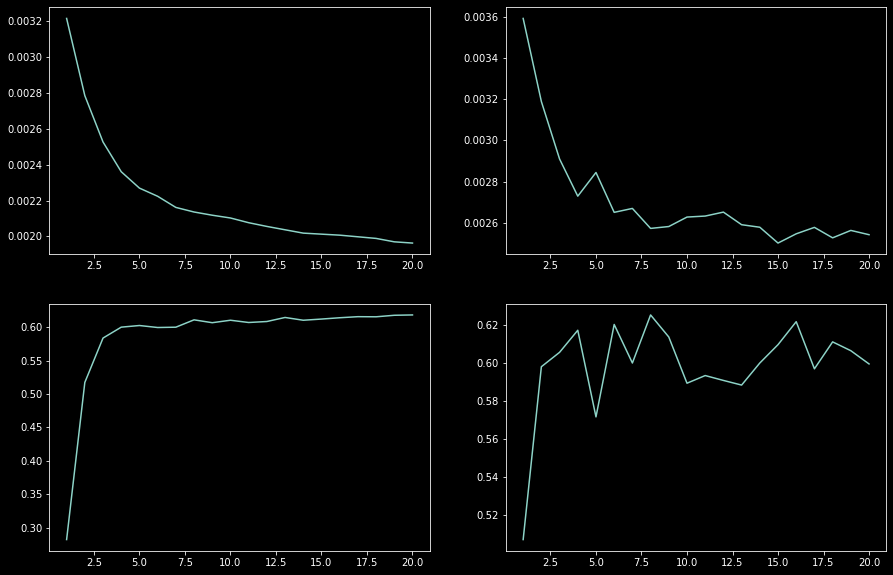

In [223]:
epochs, lr, weight_decay = 20, 0.001, 0.01
train_ls, valid_ls, train_acc, val_acc = train(DNN, epochs, lr, weight_decay, train_loader, val_loader)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0,0].plot(range(1, epochs+1), train_ls)
axes[0,1].plot(range(1, epochs+1), valid_ls)
axes[1,0].plot(range(1, epochs+1), train_acc)
axes[1,1].plot(range(1, epochs+1), val_acc)

In [224]:
# Logistic Regression
LR.fit(train_x, train_y)
pred = LR.predict(train_x)
LR_acc = accuracy_score(pred, train_y)
LR_acc, np.mean(val_acc)

# X.shape, y.shape, test.shape

(0.6258215962441315, 0.5985572076612902)

In [225]:
p = LR.predict(testset_comp)
submission = pd.read_csv('./data/happiness_submit.csv')
submission['happiness'] = np.array(p) + 1
# submission.to_csv('LR_submission.csv', index=False)

submission['happiness'].value_counts()

4    2658
3     117
5     106
2      72
1      15
Name: happiness, dtype: int64

## Predict

In [226]:
DNN.eval()
prediction = []
with torch.no_grad():
  for i, input in enumerate(test_loader):
    test_pred = DNN(input)
    # print(test_pred)
    pred_ = np.argmax(test_pred.numpy(), axis=1)
    prediction += pred_.tolist()

submission = pd.read_csv('./data/happiness_submit.csv')
submission
submission['happiness'] = np.array(prediction) + 1
# submission.to_csv('DNN_submission.csv', index=False)

submission['happiness'].value_counts()

4    2836
3      84
5      39
2       9
Name: happiness, dtype: int64